In [ ]:
#Mounting of drives
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing necessary libraries for the codes.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from tqdm import tqdm     #progress bar
from torch import Tensor,deg2rad,sin,asin,cos,sqrt,min,max#
from torch.utils.data import DataLoader
pd.set_option('display.max_columns', None)

In [ ]:
#Reading the initial and final controller location with the raw dataset itself.
proposed=pd.read_csv('/content/drive/MyDrive/dlscgnew_data.csv')
nsga2=pd.read_csv('/content/drive/MyDrive/nsga2optimisednew_data.csv')
nsga3=pd.read_csv('/content/drive/MyDrive/nsga3optimisednew_data.csv')
mopso=pd.read_csv('/content/drive/MyDrive/mopsooptimisednew_data.csv')
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv')
#proposed=pd.read_csv('/content/drive/MyDrive/new_autograd1.csv')
#nsga2=pd.read_csv('/content/drive/MyDrive/nsga2optimised_data.csv')
#nsga3=pd.read_csv('/content/drive/MyDrive/nsga3optimised_data.csv')
#mopso=pd.read_csv('/content/drive/MyDrive/mopsooptimised_data.csv')
#auto=pd.read_csv('/content/drive/MyDrive/rcgautonew.csv')
#proposed=pd.read_csv('/content/drive/MyDrive/new_autogradNEW.csv')


In [ ]:
#Correcting the columns name in the excel files.
kk=nsga2.columns[5:]
kkk=nsga3.columns[5:]
kkkk=mopso.columns[5:]
nsga2.columns=['input_'+str(col) for col in range(5)]+kk.values.tolist()
nsga3.columns=['input_'+str(col) for col in range(5)]+kkk.values.tolist()
mopso.columns=['input_'+str(col) for col in range(5)]+kkkk.values.tolist()

In [ ]:
#Verifying the columns using one of the optimization algorithms
nsga2

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),core_load(%)
0,6,15,8,5,7,1,3,8,0,2,1575668.154,16.84,0.03125
1,16,0,10,12,17,0,3,1,8,2,1575668.154,16.84,0.03125
2,2,15,0,12,4,9,15,1,17,20,1575668.154,16.84,0.03125
3,8,15,18,3,17,9,15,1,17,20,1575668.154,16.84,0.03125
4,18,17,19,9,6,9,14,20,3,1,1575668.154,16.84,0.03125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0,10,7,13,5,0,3,1,8,2,1575668.154,16.84,0.03125
451,11,0,13,6,18,0,1,8,2,3,1575668.154,16.84,0.03125
452,9,8,15,10,7,1,3,8,0,2,1575668.154,16.84,0.03125
453,19,2,8,12,14,0,3,1,8,2,1575668.154,16.84,0.03125


In [ ]:
#Naming the algorithm and joining them together for comparison
proposed['optimization algorithm']='proposed'
nsga3['optimization algorithm']='nsga3'
nsga2['optimization algorithm']='ngsa2'
mopso['optimization algorithm']='mopso'
all_data=pd.concat([proposed,nsga3,nsga2,mopso])
#all_data.rename(columns={'exec_time':'exec_time(s)'},inplace=True)
all_data.reset_index(inplace=True,drop=True)

In [ ]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),optimization algorithm
0,10,12,0,17,11,14,20,3,6,9,430.428104,9.90,NaN,0.0000,proposed
1,2,1,16,13,9,2,5,16,20,9,430.428104,9.90,NaN,0.0000,proposed
2,10,18,14,13,5,10,18,14,13,5,430.428104,9.90,NaN,0.0000,proposed
3,18,11,0,16,20,4,9,1,15,20,430.428104,9.90,NaN,0.0000,proposed
4,20,16,3,11,10,20,17,1,9,10,430.428104,9.90,NaN,0.0000,proposed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,17,10,18,4,5,0,1,20,19,2,43704.789330,17.62,NaN,0.0625,mopso
1816,12,13,18,15,9,0,20,1,19,2,43704.789330,17.62,NaN,0.0625,mopso
1817,9,19,16,7,13,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso
1818,7,18,4,1,15,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso


In [ ]:
all_data['total_cpu_usage']=all_data['exec_time(s)']*all_data['avg_cpu_util(%)']

In [ ]:

pos_tensors=Tensor(pos_data[['Lat','Lon']].values)

In [ ]:
def haversine(loc1, loc2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      lat1=loc1[:,0]
      lon1=loc1[:,1]
      lat2=loc2[0]
      lon2=loc2[1]
      dLat = deg2rad(lat2 - lat1)# CONVERTING DEGREES TO RADIANS
      dLon = deg2rad(lon2 - lon1)
      lat1 = deg2rad(lat1)
      lat2 = deg2rad(lat2)
      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))
      return R * c # RETURNS THE HAVERSINE DISTANCE

In [ ]:
k,l=1,1
m,n=0.001,0.001
#p=0.001
#q=0.3
#z=0.2

In [ ]:
def maxn2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,5):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = min(min_dists, dists)
  return min_dists.max()
# THE SECOND OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MEAN OF THE MINIMUM NODE TO CONTROLLER LATENCY
def mean2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,5):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = min(min_dists, dists)
    return min_dists.mean()
# THE THIRD OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS MAXIMUM INTERCONTROLLER LATENCY
def maxC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  max_dists = dists
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i])
    max_dists = max(max_dists, dists)
  return max_dists.max()
# THE FOURTH OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS DIVISION OF THE SUM OF INTERCONTROLLER LATENCY BY 5C2
def meanC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  sum_dists = dists.sum()
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i]).sum()
    sum_dists = sum_dists+ dists
  return sum_dists/20
def all_losses(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  return np.array([l1,l2,l3,l4])

def overall_loss(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs+0.0001).item()
  l4=meanC2C_fn(cont_locs,cont_locs+0.0001).item()
  return k*l1 + l*l2+m*l3+n*l4#+p*l5

In [ ]:
inp_cols=all_data.columns[:5]
out_cols=all_data.columns[5:10]
losses=['maxn2C','mean2C','maxC2C','meanC2C']
inp_losses_cols=['inp_'+col for col in losses ]
out_losses_cols=['out_'+col for col in losses ]

In [ ]:
#This is just like finding the accuracy or mean squared error to see if the tensors with the objective metrics improved
for row in tqdm(range(all_data.shape[0])):
  inp_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[inp_cols].values[row]])
  out_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[out_cols].values[row]])
  all_data.loc[row,inp_losses_cols]=all_losses(pos_tensors,inp_cont_locs)
  all_data.loc[row,"final input_loss"]=overall_loss(pos_tensors,inp_cont_locs)
  all_data.loc[row,out_losses_cols]=all_losses(pos_tensors,out_cont_locs)
  all_data.loc[row, "final output_loss"]=overall_loss(pos_tensors,out_cont_locs)
  #inp_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[inp_losses_cols].values[row]])
  #out_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[out_losses_cols].values[row]])
  #all_data.loc[row,inp_losses_cols]=overall_loss(pos_tensors,inp_cont_locs)
  #all_data.loc[row,out_losses_cols]=overall_loss(pos_tensors,out_cont_locs)

100%|██████████| 1820/1820 [00:39<00:00, 45.94it/s]


In [ ]:
out_cont_locs

tensor([[59.3326, 18.0649],
        [57.7072, 11.9668],
        [52.3740,  4.8897],
        [50.8504,  4.3488],
        [53.3440, -6.2672]])

In [ ]:
#The difference between the initial and final was calculated to see if the model actually improve
diff_losses=['diff_'+col[4:] for col in inp_losses_cols]
all_data[diff_losses]=all_data[inp_losses_cols].values-all_data[out_losses_cols].values

In [ ]:
#Summing up so we can have an overall loss
all_data['inp_total_loss']=all_data[inp_losses_cols].sum(axis=1)
all_data['out_total_loss']=all_data[out_losses_cols].sum(axis=1)
all_data['diff_loss']=all_data['inp_total_loss']-all_data['out_total_loss']

In [ ]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),optimization algorithm,total_cpu_usage,inp_maxn2C,inp_mean2C,inp_maxC2C,inp_meanC2C,final input_loss,out_maxn2C,out_mean2C,out_maxC2C,out_meanC2C,final output_loss,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,inp_total_loss,out_total_loss,diff_loss
0,10,12,0,17,11,14,20,3,6,9,430.428104,9.90,NaN,0.0000,proposed,4261.238233,491.784576,497.704620,1832.441528,1008.077637,992.329724,324.684998,389.147034,1416.405884,767.723511,716.016170,167.099579,108.557587,416.035645,240.354126,3830.008362,2897.961426,932.046936
1,2,1,16,13,9,2,5,16,20,9,430.428104,9.90,NaN,0.0000,proposed,4261.238233,548.720642,446.056824,1093.516846,714.425354,996.585418,324.684998,387.781677,1416.405884,809.715942,714.692806,224.035645,58.275146,-322.889038,-95.290588,2802.719666,2938.588501,-135.868835
2,10,18,14,13,5,10,18,14,13,5,430.428104,9.90,NaN,0.0000,proposed,4261.238233,679.705383,392.170105,833.735413,439.788269,1073.149020,679.705383,392.170105,833.735413,439.788269,1073.149020,0.000000,0.000000,0.000000,0.000000,2345.399170,2345.399170,0.000000
3,18,11,0,16,20,4,9,1,15,20,430.428104,9.90,NaN,0.0000,proposed,4261.238233,489.011963,383.059326,1611.742676,955.180969,874.638222,349.079437,365.303070,1416.405884,745.275940,716.544198,139.932526,17.756256,195.336792,209.905029,3438.994934,2876.064331,562.930603
4,20,16,3,11,10,20,17,1,9,10,430.428104,9.90,NaN,0.0000,proposed,4261.238233,476.219574,510.452698,1611.742676,947.008972,989.231032,349.079437,339.627350,1416.405884,772.900879,690.896103,127.140137,170.825348,195.336792,174.108093,3545.423920,2878.013550,667.410370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,17,10,18,4,5,0,1,20,19,2,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,933.175720,390.588074,614.824829,290.037781,1324.668662,922.657776,465.160583,818.883728,531.142334,1389.168394,10.517944,-74.572510,-204.058899,-241.104553,2228.626404,2737.844421,-509.218018
1816,12,13,18,15,9,0,20,1,19,2,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,629.235840,540.707153,1618.217773,832.284180,1172.393504,922.657776,569.920227,818.883728,531.142334,1493.928038,-293.421936,-29.213074,799.334045,301.141846,3620.444946,2842.604065,777.840881
1817,9,19,16,7,13,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,629.235840,485.574768,1207.625732,726.670227,1116.744913,922.657776,465.160583,818.883728,438.552155,1389.075804,-293.421936,20.414185,388.742004,288.118073,3049.106567,2645.254242,403.852325
1818,7,18,4,1,15,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,933.175720,395.291016,692.549072,353.443787,1329.512731,922.657776,465.160583,818.883728,438.552155,1389.075804,10.517944,-69.869568,-126.334656,-85.108368,2374.459595,2645.254242,-270.794647


In [ ]:
all_data.to_csv("mydatanew.csv")
all_data.head()


,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),optimization algorithm,total_cpu_usage,inp_maxn2C,inp_mean2C,inp_maxC2C,inp_meanC2C,final input_loss,out_maxn2C,out_mean2C,out_maxC2C,out_meanC2C,final output_loss,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,inp_total_loss,out_total_loss,diff_loss
0,10,12,0,17,11,14,20,3,6,9,430.428104,9.9,NaN,0.0,proposed,4261.238233,491.784576,497.704620,1832.441528,1008.077637,992.329724,324.684998,389.147034,1416.405884,767.723511,716.016170,167.099579,108.557587,416.035645,240.354126,3830.008362,2897.961426,932.046936
1,2,1,16,13,9,2,5,16,20,9,430.428104,9.9,NaN,0.0,proposed,4261.238233,548.720642,446.056824,1093.516846,714.425354,996.585418,324.684998,387.781677,1416.405884,809.715942,714.692806,224.035645,58.275146,-322.889038,-95.290588,2802.719666,2938.588501,-135.868835
2,10,18,14,13,5,10,18,14,13,5,430.428104,9.9,NaN,0.0,proposed,4261.238233,679.705383,392.170105,833.735413,439.788269,1073.149020,679.705383,392.170105,833.735413,439.788269,1073.149020,0.000000,0.000000,0.000000,0.000000,2345.399170,2345.399170,0.000000
3,18,11,0,16,20,4,9,1,15,20,430.428104,9.9,NaN,0.0,proposed,4261.238233,489.011963,383.059326,1611.742676,955.180969,874.638222,349.079437,365.303070,1416.405884,745.275940,716.544198,139.932526,17.756256,195.336792,209.905029,3438.994934,2876.064331,562.930603
4,20,16,3,11,10,20,17,1,9,10,430.428104,9.9,NaN,0.0,proposed,4261.238233,476.219574,510.452698,1611.742676,947.008972,989.231032,349.079437,339.627350,1416.405884,772.900879,690.896103,127.140137,170.825348,195.336792,174.108093,3545.423920,2878.013550,667.410370


In [ ]:
#Grouping all the algorithm according to the category and find the mean of all the losses
means=all_data.groupby('optimization algorithm').mean().reset_index()
means

,optimization algorithm,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),total_cpu_usage,inp_maxn2C,inp_mean2C,inp_maxC2C,inp_meanC2C,final input_loss,out_maxn2C,out_mean2C,out_maxC2C,out_meanC2C,final output_loss,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,inp_total_loss,out_total_loss,diff_loss
0,mopso,9.470330,9.345055,9.461538,9.028571,9.742857,10.373626,10.712088,10.595604,9.439560,9.951648,4.370479e+04,17.62,NaN,0.06250,7.700784e+05,764.120081,419.022451,1056.911572,599.210310,1184.798660,899.134179,559.365436,824.117624,537.866202,1459.861607,-135.014098,-140.342985,232.793948,61.344108,2839.264414,2820.483441,18.780973
1,ngsa2,9.573626,9.734066,9.778022,9.619780,9.248352,1.336264,6.048352,9.391209,4.960440,4.131868,1.575668e+06,16.84,NaN,0.03125,2.653425e+07,751.740552,420.595448,1091.459721,617.214074,1174.044680,763.184648,467.876233,712.138256,423.823958,1232.196851,-11.444096,-47.280786,379.321465,193.390116,2881.009794,2367.023095,513.986699
2,nsga3,9.810989,9.371429,9.654945,9.909890,9.549451,3.793407,5.997802,4.107692,11.496703,9.265934,1.623746e+06,16.98,NaN,0.03125,2.757121e+07,753.228765,416.447860,1073.751164,608.717760,1171.359101,660.507324,476.759226,917.253997,547.060127,1138.730871,92.721441,-60.311365,156.497167,61.657633,2852.145550,2601.580674,250.564876
3,proposed,10.391209,10.336264,10.232967,10.215385,9.839560,10.347253,10.189011,10.843956,10.597802,10.846154,4.304281e+02,9.90,NaN,0.00000,4.261238e+03,722.353911,430.231628,1137.347512,642.599246,1154.365493,573.090293,368.751257,1086.228305,612.622176,943.540408,149.263618,61.480371,51.119207,29.977070,2932.532297,2640.692030,291.840267


In [ ]:
#Not needed
N2c_cols=[col for col in all_data.columns if col.endswith('n2C')]
means[N2c_cols]

,inp_maxn2C,inp_mean2C,out_maxn2C,out_mean2C,diff_maxn2C,diff_mean2C
0,764.120081,419.022451,899.134179,559.365436,-135.014098,-140.342985
1,751.740552,420.595448,763.184648,467.876233,-11.444096,-47.280786
2,753.228765,416.447860,660.507324,476.759226,92.721441,-60.311365
3,722.353911,430.231628,573.090293,368.751257,149.263618,61.480371


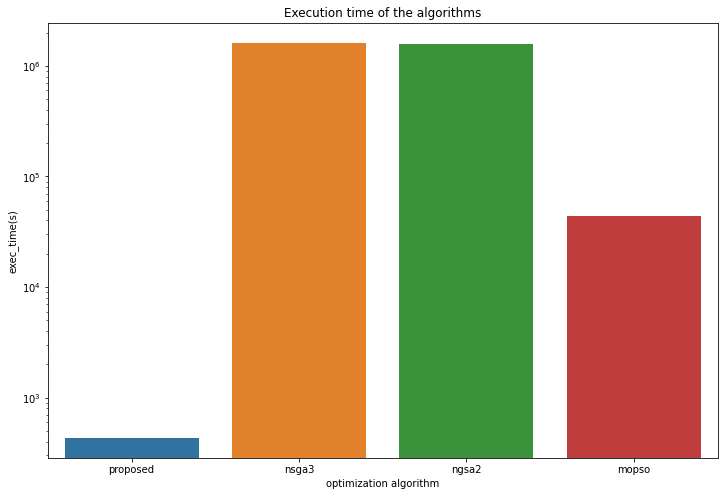

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='exec_time(s)')
plt.yscale('log')
plt.title('Execution time of the algorithms')
plt.show()

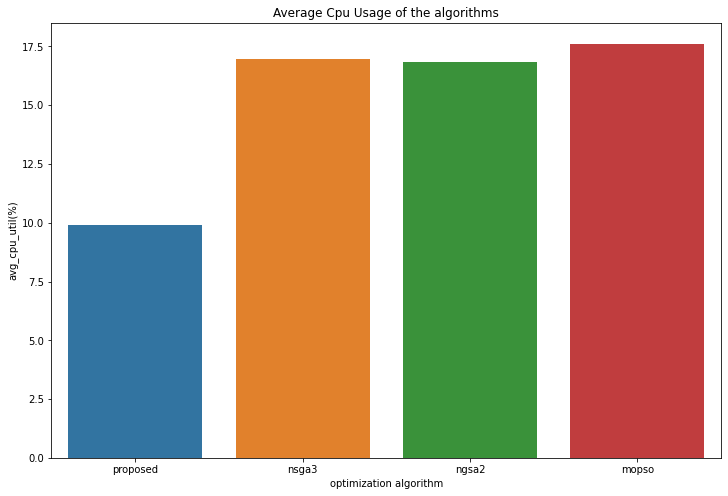

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='avg_cpu_util(%)')
plt.title('Average Cpu Usage of the algorithms')
plt.show()

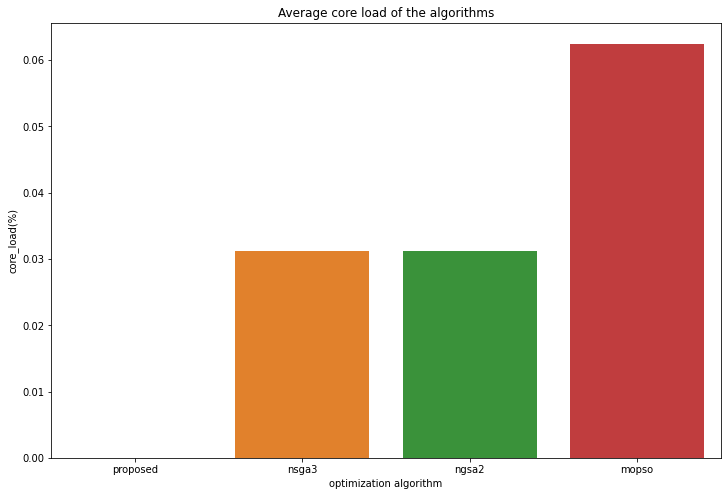

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='core_load(%)')
#plt.yscale('log')
plt.title('Average core load of the algorithms')
plt.show()

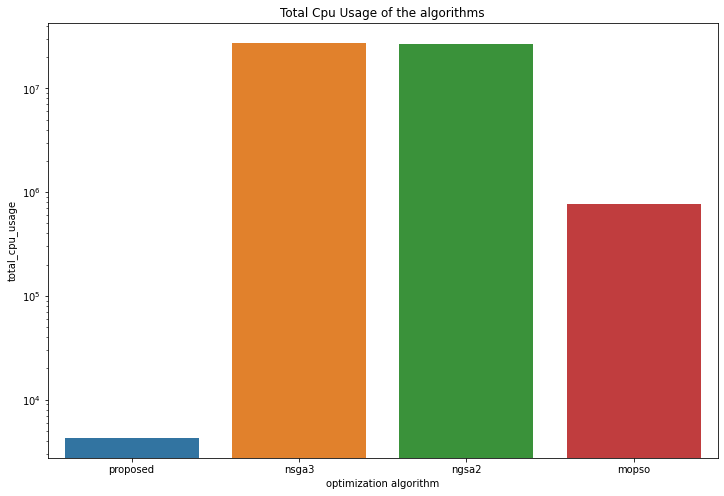

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='total_cpu_usage')
plt.yscale('log')
plt.title('Total Cpu Usage of the algorithms')
plt.show()

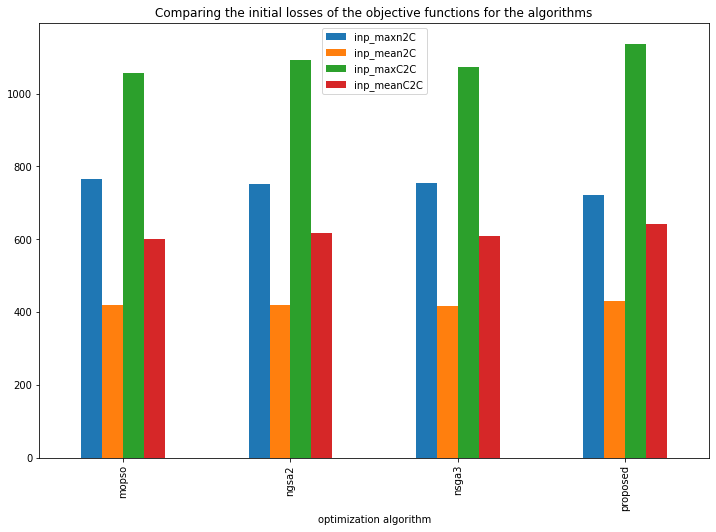

In [ ]:
means.plot(y=inp_losses_cols,x='optimization algorithm',kind='bar',figsize=(12,8))
plt.title('Comparing the initial losses of the objective functions for the algorithms')
plt.show()

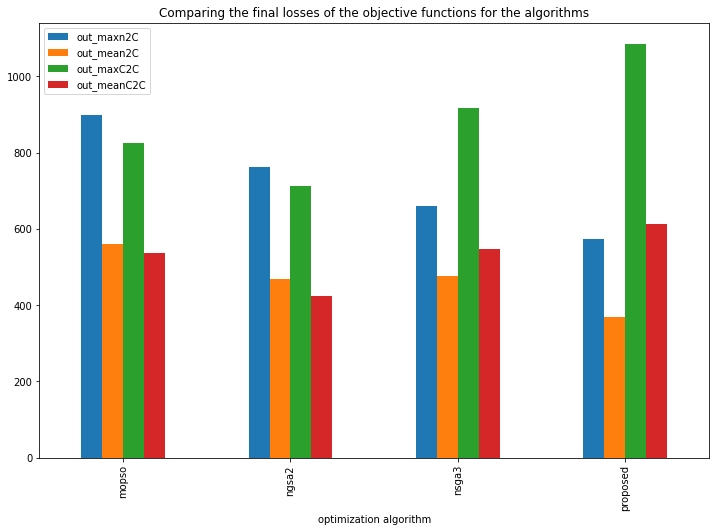

In [ ]:
means.plot(y=out_losses_cols,x='optimization algorithm',kind='bar',figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the algorithms')
plt.show()

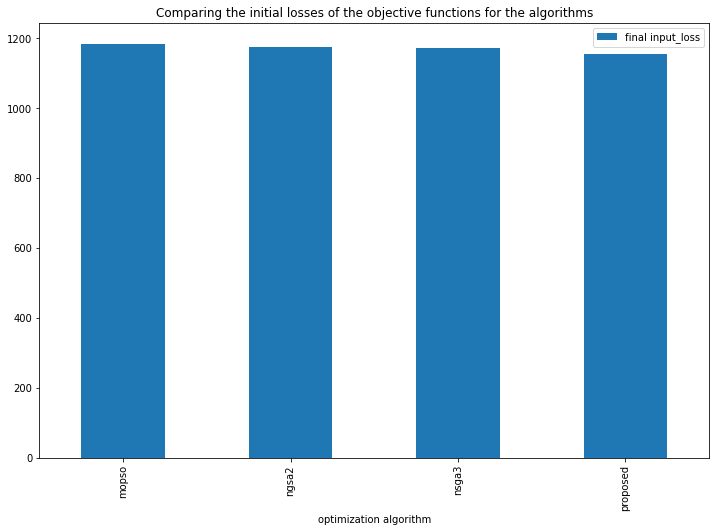

In [ ]:
means.plot(y="final input_loss",x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the initial losses of the objective functions for the algorithms')
plt.show()

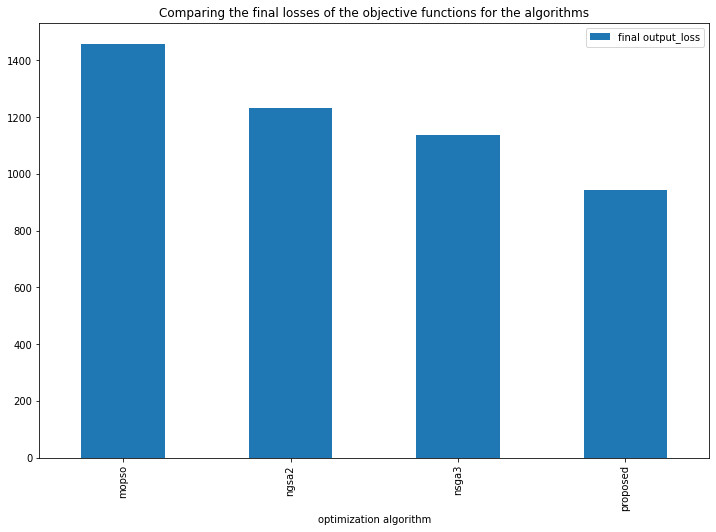

In [ ]:
means.plot(y="final output_loss",x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the algorithms')
plt.show()

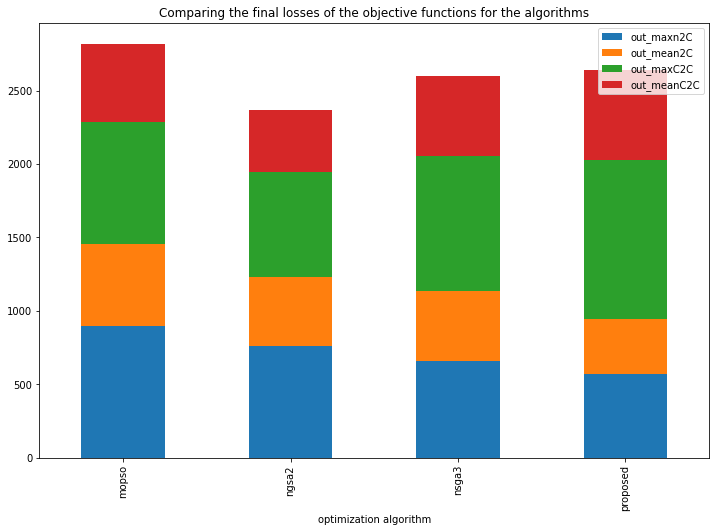

In [ ]:
means.plot(y=out_losses_cols,x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the algorithms')
plt.show()

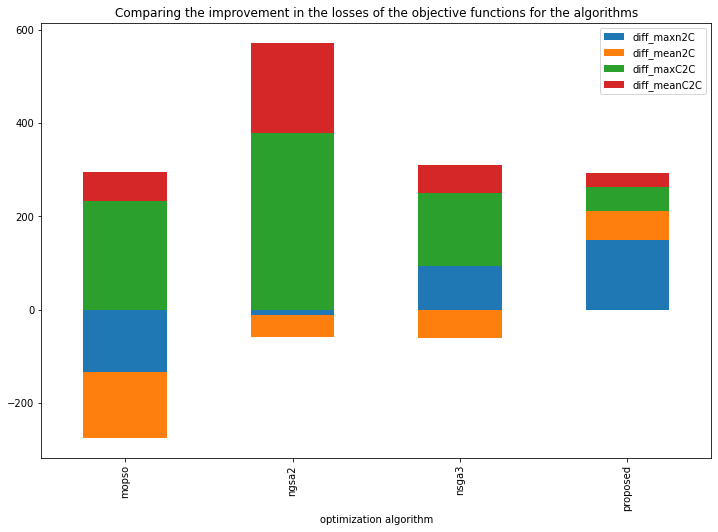

In [ ]:
means.plot(y=diff_losses,x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the improvement in the losses of the objective functions for the algorithms')
plt.show()

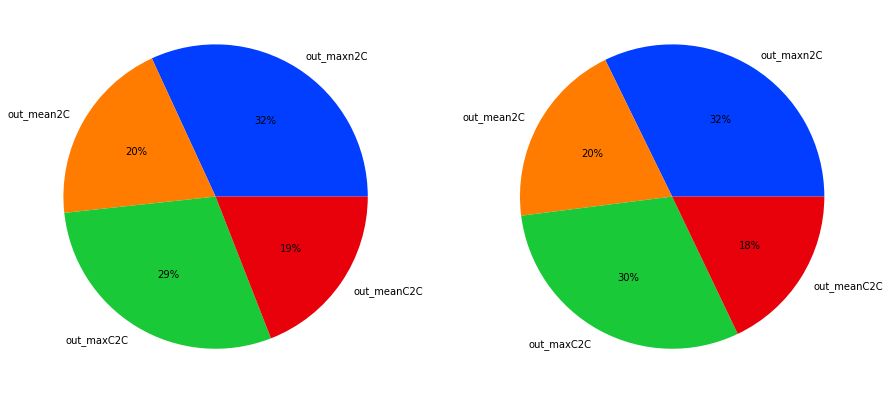

In [ ]:
palette_color = sns.color_palette('bright')
fig, ax = plt.subplots(1, 2,figsize=(15, 7))
ax[0].pie(means.loc[0,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
ax[1].pie(means.loc[1,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
plt.show()